In [ ]:
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

%matplotlib inline

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
tar = tarfile.open(name="/content/drive/MyDrive/Colab Notebooks/dmdw_mini_project_dataset/fer2013.tar.gz", mode='r:gz')

In [ ]:
df = pd.read_csv(tar.extractfile("fer2013/fer2013.csv"))
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
df["Usage"].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [ ]:
train = df[["emotion", "pixels"]][df["Usage"] == "Training"]
train.isnull().sum()

emotion    0
pixels     0
dtype: int64

The dataset is already clean!

In [ ]:
train['pixels'] = train['pixels'].apply(lambda im: np.fromstring(im, sep=' '))
x_train = np.vstack(train['pixels'].values)
y_train = np.array(train["emotion"])
x_train.shape, y_train.shape

((28709, 2304), (28709,))

In [ ]:
train.head()

,emotion,pixels
0,0,"[70.0, 80.0, 82.0, 72.0, 58.0, 58.0, 60.0, 63...."
1,0,"[151.0, 150.0, 147.0, 155.0, 148.0, 133.0, 111..."
2,2,"[231.0, 212.0, 156.0, 164.0, 174.0, 138.0, 161..."
3,4,"[24.0, 32.0, 36.0, 30.0, 32.0, 23.0, 19.0, 20...."
4,6,"[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


The pixels are vectorised and the dataset is split into training and testing datasets for the CNN model.

In [ ]:
public_test_df = df[["emotion", "pixels"]][df["Usage"]=="PublicTest"]

In [ ]:
public_test_df["pixels"] = public_test_df["pixels"].apply(lambda im: np.fromstring(im, sep=' '))
x_test = np.vstack(public_test_df["pixels"].values)
y_test = np.array(public_test_df["emotion"])

In [ ]:
x_train = x_train.reshape(-1, 48, 48, 1)
x_test = x_test.reshape(-1, 48, 48, 1)
x_train.shape, x_test.shape

((28709, 48, 48, 1), (3589, 48, 48, 1))

In [ ]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_train.shape, y_test.shape

((28709, 7), (3589, 7))

Preprocessing is done by one hot encoding.


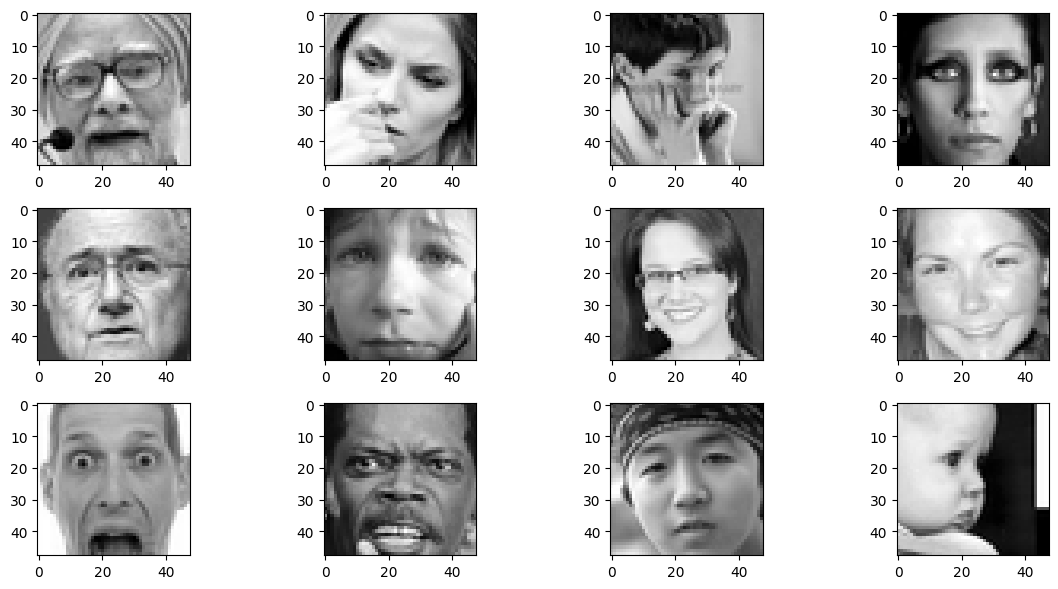

In [ ]:
import seaborn as sns
plt.figure(0, figsize=(12,6))
for i in range(1, 13):
    plt.subplot(3,4,i)
    plt.imshow(x_train[i, :, :, 0], cmap="gray")

plt.tight_layout()
plt.show()

In [ ]:
model = Sequential()

model.add(Conv2D(64, 3, data_format="channels_last", kernel_initializer="he_normal",
                 input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
# model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.6))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.6))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.6))

model.add(Dense(7))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 46, 46, 64)        640       
                                                                 
 batch_normalization_29 (Bat  (None, 46, 46, 64)       256       
 chNormalization)                                                
                                                                 
 activation_33 (Activation)  (None, 46, 46, 64)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 44, 44, 64)        36928     
                                                                 
 batch_normalization_30 (Bat  (None, 44, 44, 64)       256       
 chNormalization)                                                
                                                                 
 activation_34 (Activation)  (None, 44, 44, 64)       

This is a Convolutional Neural Network model with 7 layers:

Layer 1:

Conv2D: 64 filters of size 3x3, using the ReLU activation function and He normal initialization.
BatchNormalization: Normalizes the activations of the previous layer.
Activation: ReLU activation function.

Layer 2:

Conv2D: 64 filters of size 3x3.
BatchNormalization.
Activation: ReLU activation function.
MaxPool2D: Max pooling with a pool size of 2x2 and stride of 2 (reduces the spatial dimensions).
Dropout: Dropout regularization with a rate of 0.6 (60% of the neurons are randomly set to 0 during training).

Layer 3:

Conv2D: 32 filters of size 3x3.
BatchNormalization.
Activation: ReLU activation function.

Layer 4:

Conv2D: 32 filters of size 3x3.
BatchNormalization.
Activation: ReLU activation function.

Layer 5:

Conv2D: 32 filters of size 3x3.
BatchNormalization.
Activation: ReLU activation function.
MaxPool2D: Max pooling with a pool size of 2x2 and stride of 2.
Dropout: Dropout regularization with a rate of 0.6.

Layer 6:

Flatten: Flattens the multi-dimensional output into a one-dimensional vector.
Dense: Fully connected layer with 128 neurons.
BatchNormalization.
Activation: ReLU activation function.
Dropout: Dropout regularization with a rate of 0.6.

Layer 7:

Dense: Fully connected layer with 7 neurons (output classes).
Activation: Softmax activation function, used for multi-class classification.
The network is compiled with the categorical cross-entropy loss function, the Adam optimizer, and the accuracy metric.

In [ ]:
# save best weights
checkpointer = ModelCheckpoint(filepath='face_model.h5', verbose=1, save_best_only=True)

# num epochs
epochs = 10

# run model
hist = model.fit(x_train, y_train, epochs=epochs,
                 shuffle=True,
                 batch_size=100, validation_data=(x_test, y_test),
                 callbacks=[checkpointer], verbose=2)

# save model to json
model_json = model.to_json()
with open("face_model.json", "w") as json_file:
    json_file.write(model_json)

Epoch 1/10

Epoch 1: val_loss improved from inf to 1.52190, saving model to face_model.h5
288/288 - 27s - loss: 1.9399 - accuracy: 0.2860 - val_loss: 1.5219 - val_accuracy: 0.4096 - 27s/epoch - 93ms/step
Epoch 2/10

Epoch 2: val_loss improved from 1.52190 to 1.40574, saving model to face_model.h5
288/288 - 19s - loss: 1.5641 - accuracy: 0.3933 - val_loss: 1.4057 - val_accuracy: 0.4533 - 19s/epoch - 66ms/step
Epoch 3/10

Epoch 3: val_loss improved from 1.40574 to 1.36302, saving model to face_model.h5
288/288 - 19s - loss: 1.4442 - accuracy: 0.4412 - val_loss: 1.3630 - val_accuracy: 0.4751 - 19s/epoch - 65ms/step
Epoch 4/10

Epoch 4: val_loss improved from 1.36302 to 1.33042, saving model to face_model.h5
288/288 - 19s - loss: 1.3852 - accuracy: 0.4621 - val_loss: 1.3304 - val_accuracy: 0.4887 - 19s/epoch - 64ms/step
Epoch 5/10

Epoch 5: val_loss improved from 1.33042 to 1.28607, saving model to face_model.h5
288/288 - 19s - loss: 1.3400 - accuracy: 0.4834 - val_loss: 1.2861 - val_accur

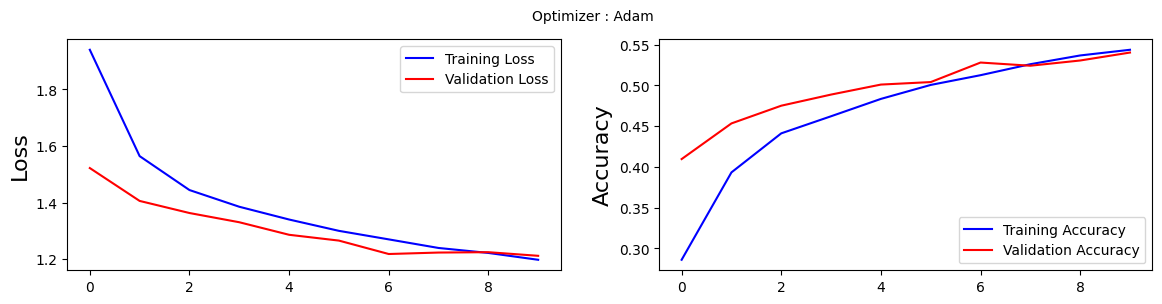

In [ ]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
test = df[["emotion", "pixels"]][df["Usage"] == "PrivateTest"]
test["pixels"] = test["pixels"].apply(lambda im: np.fromstring(im, sep=' '))
test.head()

,emotion,pixels
32298,0,"[170.0, 118.0, 101.0, 88.0, 88.0, 75.0, 78.0, ..."
32299,5,"[7.0, 5.0, 8.0, 6.0, 7.0, 3.0, 2.0, 6.0, 5.0, ..."
32300,6,"[232.0, 240.0, 241.0, 239.0, 237.0, 235.0, 246..."
32301,4,"[200.0, 197.0, 149.0, 139.0, 156.0, 89.0, 111...."
32302,2,"[40.0, 28.0, 33.0, 56.0, 45.0, 33.0, 31.0, 78...."


In [ ]:
x_test_private = np.vstack(test["pixels"].values)
y_test_private = np.array(test["emotion"])

In [ ]:
x_test_private = x_test_private.reshape(-1, 48, 48, 1)
y_test_private = np_utils.to_categorical(y_test_private)
x_test_private.shape, y_test_private.shape

((3589, 48, 48, 1), (3589, 7))

Private test data prepared for final evaluation of the model.

In [ ]:
score = model.evaluate(x_test_private, y_test_private, verbose=0)


In [ ]:
print("Cost: ",score[0])
print("Accuracy: ",score[1])

Cost:  1.1743191480636597
Accuracy:  0.5505712032318115
